In [3]:
# Libraries
from bs4 import BeautifulSoup, Comment
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import urllib
import urllib2
import os
import re
import scipy.stats as stats
import unicodedata
import datetime
import requests
import requests_cache
requests_cache.install_cache('demo_cache')
%matplotlib inline

## 1. Helper functions

In [4]:
# Convert time string to seconds int
def time_to_sec(time):
    time_list = time.split(':')
    return int(time_list[0]) * 60 + int(time_list[1])

## 2. Read in/explore data

In [5]:
season_df = pd.read_excel('data/season_data/season_data_2017.xlsx')

In [6]:
season_df.head(n=10)

,G,GS,age,ast,blk,drb,efg,fg,fg2,fg2_pct,...,player,pos,pts,stl,team,tov,trb,yr,weighted_usg,prev_weighted_usg
0,68,6,23,40,8,68,0.531,134,40,0.426,...,Alex Abrines,SG,406,37,OKC,33,86,2017,0.047907,NaN
1,38,1,26,18,15,95,0.521,70,33,0.413,...,Quincy Acy,PF,222,14,TOT,21,115,2017,0.009668,0.036719
2,6,0,26,0,0,6,0.324,5,4,0.400,...,Quincy Acy,PF,13,0,DAL,2,8,2017,0.002432,0.036719
3,32,1,26,18,15,89,0.542,65,29,0.414,...,Quincy Acy,PF,209,14,BRK,19,107,2017,0.023642,0.036719
4,80,80,23,86,78,332,0.571,374,374,0.572,...,Steven Adams,C,905,89,OKC,146,613,2017,0.109469,0.082987
5,61,45,31,78,6,116,0.514,185,123,0.457,...,Arron Afflalo,SG,515,21,SAC,42,125,2017,0.068534,0.113848
6,39,15,28,12,22,131,0.500,89,89,0.511,...,Alexis Ajinca,C,207,20,NOP,31,177,2017,0.027336,0.044005
7,62,0,28,25,23,107,0.523,45,45,0.523,...,Cole Aldrich,C,105,25,MIN,17,158,2017,0.019740,0.038858
8,72,72,31,139,88,351,0.488,500,477,0.480,...,LaMarcus Aldridge,PF,1243,46,SAS,98,523,2017,0.131592,0.131949
9,61,5,27,57,24,114,0.458,77,77,0.461,...,Lavoy Allen,PF,177,18,IND,29,219,2017,0.033932,0.066434


In [7]:
team = 'OKC'
team_df = season_df[season_df['team'] == 'OKC']

In [8]:
team_df.head()

,G,GS,age,ast,blk,drb,efg,fg,fg2,fg2_pct,...,player,pos,pts,stl,team,tov,trb,yr,weighted_usg,prev_weighted_usg
0,68,6,23,40,8,68,0.531,134,40,0.426,...,Alex Abrines,SG,406,37,OKC,33,86,2017,0.047907,NaN
4,80,80,23,86,78,332,0.571,374,374,0.572,...,Steven Adams,C,905,89,OKC,146,613,2017,0.109469,0.082987
99,64,1,24,130,7,68,0.372,77,65,0.406,...,Semaj Christon,PG,183,28,OKC,43,87,2017,0.039603,NaN
102,13,0,28,14,0,11,0.337,16,13,0.333,...,Norris Cole,PG,43,8,OKC,7,11,2017,0.006565,0.063261
104,20,0,36,12,2,22,0.609,14,14,0.636,...,Nick Collison,PF,33,2,OKC,4,31,2017,0.004873,0.026998


## 3. Create season Gini coefficients

In [9]:
# Calculate usage rate as per basketball-reference equation
usg_pct = [(100 * ((fga + 0.44*fta + tov)) * (float(sum(team_df['mp']))/5)) / 
            (mp * (sum(team_df['fga']) + 0.44*sum(team_df['fta']) + sum(team_df['tov'])))
for fga, fta, tov, mp in zip(team_df['fga'], team_df['fta'], team_df['tov'], team_df['mp'])]

In [10]:
usg_pct

[15.973872573315784,
 16.301154515748923,
 12.244378899084404,
 21.6087453698326,
 10.158389637459505,
 19.61008444356776,
 11.813601238805544,
 15.722247826834545,
 13.743223624855373,
 27.38550224122029,
 17.84409741100437,
 13.621388349371768,
 16.33764614659761,
 21.45078464171193,
 19.672393877208602,
 10.092269172366226,
 15.493025677895476,
 11.229748658950655,
 41.79205417964317]

In [11]:
weighted_def = [mp * 20 for mp in team_df['mp']]

In [12]:
weighted_def

[21100,
 47780,
 19460,
 2500,
 2560,
 9740,
 29800,
 620,
 1240,
 30660,
 14780,
 8600,
 12540,
 44440,
 6400,
 47520,
 32640,
 7700,
 56040]

### 3.1. Offense Gini component

In [13]:
# Function for calculating usage rate for a team
# team_df: a dataframe of a single team's season statistics
def calculate_weighted_off_usg(team_df):
    # Multiply by MP to weight Gini, essentially MP in numerator and denominator cancel
    weighted_off = [mp * (100 * ((fga + 0.44*fta + tov)) * (float(sum(team_df['mp']))/5)) / 
                (mp * (sum(team_df['fga']) + 0.44*sum(team_df['fta']) + sum(team_df['tov'])))
    for fga, fta, tov, mp in zip(team_df['fga'], team_df['fta'], team_df['tov'], team_df['mp'])]
    return weighted_off

In [14]:
# Function for calculating usage rate for a team
# team_df: a dataframe of a single team's season statistics
def calculate_weighted_off_usg_2(team_df):
    # Multiply by MP to weight Gini, essentially MP in numerator and denominator cancel
    weighted_off = [(100 * ((fga + 0.44*fta + tov))) / 
                ((sum(team_df['fga']) + 0.44*sum(team_df['fta']) + sum(team_df['tov'])))
    for fga, fta, tov, mp in zip(team_df['fga'], team_df['fta'], team_df['tov'], team_df['mp'])]
    return weighted_off

### 3.2. Defensive Gini component

In [15]:
def calculate_weighted_def_usg(team_df):
    weighted_def = [mp * 20 for mp in team_df['mp']]
    return weighted_def

In [16]:
def calculate_weighted_def_usg_2(team_df):
    weighted_def = [float(mp)/(sum(team_df['mp'])/5) * 20 for mp in team_df['mp']]
    return weighted_def

### 3.3. All together

In [17]:
off_usg = calculate_weighted_off_usg_2(team_df)
def_usg = calculate_weighted_def_usg_2(team_df)
len(off_usg) == len(def_usg)

True

In [18]:
zip(off_usg, def_usg)

[(4.254376341726789, 5.326937642009594),
 (9.831227440705891, 12.062610451906083),
 (3.007619072202647, 4.912900782630649),
 (0.6818876025520234, 0.6311537490532694),
 (0.32825251782157344, 0.6463014390305478),
 (2.4109136433448195, 2.4589750063115376),
 (4.443670061047224, 7.52335268871497),
 (0.12304091755828309, 0.1565261297652108),
 (0.21510649922776764, 0.3130522595304216),
 (10.598297216952112, 7.740469578389295),
 (3.328988182048932, 3.7313809644029283),
 (1.4786420756916745, 2.1711688967432465),
 (2.5860103337162226, 3.1658672052511996),
 (12.032627353802866, 11.219389043170915),
 (1.5892068162947472, 1.6157535975763695),
 (6.053527101267837, 11.996970462004544),
 (6.383070258084777, 8.240343347639485),
 (1.091450377081693, 1.9439535470840696),
 (29.562086188872108, 14.147942438778088)]

In [19]:
weighted_usg = [(o_usg + d_usg)/2 for o_usg, d_usg in zip(off_usg, def_usg)]
weighted_usg

[4.790656991868191,
 10.946918946305988,
 3.960259927416648,
 0.6565206758026464,
 0.48727697842606066,
 2.4349443248281784,
 5.983511374881097,
 0.13978352366174696,
 0.26407937937909465,
 9.169383397670703,
 3.53018457322593,
 1.8249054862174605,
 2.875938769483711,
 11.62600819848689,
 1.6024802069355584,
 9.02524878163619,
 7.311706802862131,
 1.5177019620828813,
 21.855014313825098]

In [20]:
def calculate_weighted_usg(team_df):
    off_usg = calculate_weighted_off_usg(team_df)
    def_usg = calculate_weighted_def_usg(team_df)
    weighted_usg = [(o_usg + d_usg)/2 for o_usg, d_usg in zip(off_usg, def_usg)]
    return weighted_usg

In [21]:
def calculate_weighted_usg_2(team_df):
    off_usg = calculate_weighted_off_usg_2(team_df)
    def_usg = calculate_weighted_def_usg_2(team_df)
    weighted_usg = [(o_usg + d_usg)/2 for o_usg, d_usg in zip(off_usg, def_usg)]
    return weighted_usg

In [22]:
# Take weighted usage rates, normalize them (sum = 1), sort them
def get_norm_usg(w_usg):
    return sorted([u/sum(w_usg) for u in w_usg])

In [23]:
# Subset only the top k usages, renormalize them
def get_norm_top_k(n_usg, k):
    new_usg = n_usg[-k:]
    return get_norm_usg(new_usg)

In [24]:
# Using the boston df, calculate usage with n=2
usg = calculate_weighted_usg(team_df)
# Normalize usage
n_usg = get_norm_usg(usg)
n_usg

[0.0013977957217912137,
 0.002640714764138434,
 0.004872606626268324,
 0.006565047424049626,
 0.015176528872180153,
 0.01602439417437488,
 0.018248506753294282,
 0.02434882248310803,
 0.02875858847560929,
 0.03530090374978823,
 0.039601359018490774,
 0.0479052251399174,
 0.05983321448780707,
 0.07311498776421971,
 0.09024945919613016,
 0.09169187990481509,
 0.10946614427209456,
 0.11625724966409665,
 0.21854657150782617]

In [25]:
sum(n_usg[-3:])

0.44426996544401737

In [26]:
usg = calculate_weighted_usg_2(team_df)
print sorted(usg)
print sum(usg)

[0.13978352366174696, 0.26407937937909465, 0.48727697842606066, 0.6565206758026464, 1.5177019620828813, 1.6024802069355584, 1.8249054862174605, 2.4349443248281784, 2.875938769483711, 3.53018457322593, 3.960259927416648, 4.790656991868191, 5.983511374881097, 7.311706802862131, 9.02524878163619, 9.169383397670703, 10.946918946305988, 11.62600819848689, 21.855014313825098]
100.002524615


In [27]:
n_usg_k = get_norm_top_k(n_usg, k=9)
n_usg_k

[0.04677329048787544,
 0.05658101304831995,
 0.07066919902306455,
 0.08635634348095253,
 0.10659392192533727,
 0.10829756959009407,
 0.12929080949559515,
 0.13731180557013836,
 0.2581260473786226]

## 4. Plot and calculate functions for Gini

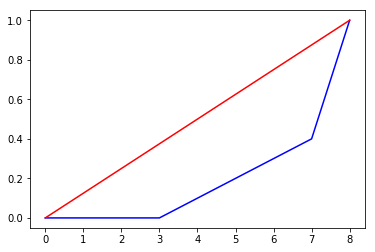

0.703125
1.42222222222


In [28]:
# 0 through length
#x = range(len(n_usg_k)+1)
x = range(9)
# Cumulative sum
#y1 = np.cumsum([0] + n_usg_k)
y1 = [0,0,0,0,.1,.2,.3,.4,1]

# y=x line
y2 = [float(t)/(len(x)-1) for t in x]
plt.plot(x, y1, c='b')
plt.plot(x, y2, c='r')
plt.show()

gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(x)/(len(x)-1)
print gini
print 1/gini

In [29]:
def get_gini_season(yr, team, k):
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    season_df = season_df[season_df['mp'] != 0]
    
    team_df = season_df[season_df['team'] == team]
    usg = calculate_weighted_usg_2(team_df)
    n_usg = get_norm_usg(usg)
    n_usg_k = get_norm_top_k(n_usg, k=k)
    x = range(len(n_usg_k)+1)
    y1 = np.cumsum([0] + n_usg_k)
    y2 = [float(t)/(len(x)-1) for t in x]
    gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(n_usg_k)/(len(n_usg_k)-1)
    return gini

In [30]:
yr = 2017
team = 'OKC'
get_gini_season(yr, team, 9)

0.30669406813649913

In [31]:
def plot_gini_season(yr, team, k):
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    season_df = season_df[season_df['mp'] != 0]
    
    team_df = season_df[season_df['team'] == team]
    usg = calculate_weighted_usg(team_df)
    n_usg = get_norm_usg(usg)
    n_usg_k = get_norm_top_k(n_usg, k=k)
    x = range(len(n_usg_k)+1)
    y1 = np.cumsum([0] + n_usg_k)
    y2 = [float(t)/(len(x)-1) for t in x]
    gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(n_usg_k)/(len(n_usg_k)-1)
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)

    ax.set_xlabel('Player')
    ax.set_ylabel('Cumulative weighted usage')

    ax.text(1.5, 0.5, 'Gini: '+ str(round(gini,3)), fontsize=12)
    
    ax.plot(x, y1, c='black')
    ax.plot(x, y2, c='black')
    ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='orange', interpolate=True)
    ax.set_title('Team: ' + team + ', Season: ' + str(yr))
    plt.show()

In [35]:
df = pd.read_excel('data/nba_results_gini_new.xlsx')

In [36]:
df.sort_values(['gini'])

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,gini,alt_abbr
44,Philadelphia 76ers,10,72,0.122,16,66,97.4,107.6,2016,PHI,0,0.048224,PHI
84,Los Angeles Lakers,21,61,0.256,23,59,98.5,105.3,2015,LAL,0,0.094376,LAL
388,Memphis Grizzlies,45,37,0.549,48,34,93.4,91.1,2005,MEM,1,0.101395,MEM
139,Minnesota Timberwolves,31,51,0.378,34,48,95.7,98.1,2013,MIN,0,0.102828,MIN
132,Washington Wizards,29,53,0.354,33,49,93.2,95.8,2013,WAS,0,0.107458,WAS
178,Houston Rockets,34,32,0.515,34,32,98.1,97.9,2012,HOU,0,0.110815,HOU
23,Denver Nuggets,40,42,0.488,42,40,111.7,111.2,2017,DEN,0,0.111168,DEN
408,Memphis Grizzlies,50,32,0.610,48,34,96.7,94.3,2004,MEM,1,0.118690,MEM
51,Memphis Grizzlies,42,40,0.512,35,47,99.1,101.3,2016,MEM,1,0.120931,MEM
19,Los Angeles Clippers,51,31,0.622,52,30,108.7,104.4,2017,LAC,1,0.122063,LAC


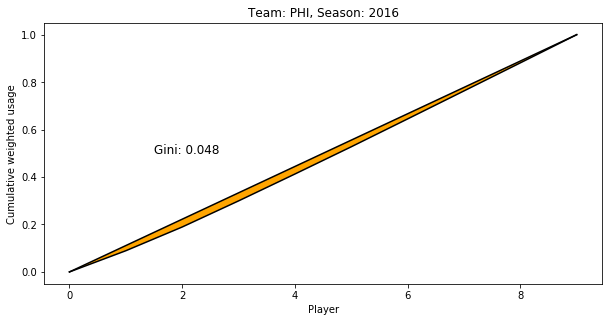

In [39]:
yr = 2016
team = 'PHI'
plot_gini_season(yr, team, 9)

## Big 3 type thing

In [231]:
# Using the boston df, calculate usage with n=2
usg = calculate_weighted_usg(team_df)
# Normalize usage
n_usg = get_norm_usg(usg)
n_usg

[0.0013977957217912137,
 0.002640714764138434,
 0.004872606626268324,
 0.006565047424049626,
 0.015176528872180153,
 0.01602439417437488,
 0.018248506753294282,
 0.02434882248310803,
 0.02875858847560929,
 0.03530090374978823,
 0.039601359018490774,
 0.0479052251399174,
 0.05983321448780707,
 0.07311498776421971,
 0.09024945919613016,
 0.09169187990481509,
 0.10946614427209456,
 0.11625724966409665,
 0.21854657150782617]

In [232]:
sum(n_usg[-3:])

0.44426996544401737

In [234]:
def get_top_3(team, yr):
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    season_df = season_df[season_df['mp'] != 0]
    
    team_df = season_df[season_df['team'] == team]
    usg = calculate_weighted_usg(team_df)
    n_usg = get_norm_usg(usg)
    return sum(n_usg[-3:])

In [240]:
get_top_3('GSW', 2017)

0.44725351457981755

## Palma ratio function

In [286]:
team = 'BOS'
yr = 2017
season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
season_df = season_df[season_df['mp'] != 0]

team_df = season_df[season_df['team'] == team]
usg = calculate_weighted_usg_2(team_df)
n_usg = get_norm_usg(usg)
n_usg_k = get_norm_top_k(n_usg, k=10)

In [287]:
n_usg_k

[0.05279659627537663,
 0.06394841827952936,
 0.06962474291254256,
 0.07357859708551996,
 0.08182123906358774,
 0.10482994663580365,
 0.11792574726551909,
 0.11891386707808559,
 0.12710722557876344,
 0.18945361982527198]

In [288]:
n_usg_k[-1]/float(sum(n_usg_k[:4]))

0.7288125372098397

In [282]:
n_usg_k[:4]

[0.04677359542371022,
 0.05658119821887059,
 0.07066968971514484,
 0.08635665893701899]

In [295]:
def get_palma(team, yr, k):
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    season_df = season_df[season_df['mp'] != 0]

    team_df = season_df[season_df['team'] == team]
    usg = calculate_weighted_usg_2(team_df)
    n_usg = get_norm_usg(usg)
    n_usg_k = get_norm_top_k(n_usg, k=k)
    palma = n_usg_k[-1]/float(sum(n_usg_k[:4]))
    return palma

## Calculate Big 3 for all teams, all seasons

In [242]:
yrs = range(1986, 2018)

big3_df = pd.DataFrame()
for yr in yrs:
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    season_df = season_df[season_df['mp'] != 0]
    
    teams = np.unique(season_df['team'])
    teams = teams[teams != 'TOT']
    for team in teams:
        print team, yr
        big3 = get_top_3(team, yr)
        #gini10 = get_gini_season(yr, team, k=10)
        big3_df = big3_df.append({'team': team,
                                  'season': yr,
                                  'big3': big3}, 
                                  ignore_index=True)
big3_df.to_excel('data/big3.xlsx')

ATL 1986
BOS 1986
CHI 1986
CLE 1986
DAL 1986
DEN 1986
DET 1986
GSW 1986
HOU 1986
IND 1986
LAC 1986
LAL 1986
MIL 1986
NJN 1986
NYK 1986
PHI 1986
PHO 1986
POR 1986
SAC 1986
SAS 1986
SEA 1986
UTA 1986
WSB 1986
ATL 1987
BOS 1987
CHI 1987
CLE 1987
DAL 1987
DEN 1987
DET 1987
GSW 1987
HOU 1987
IND 1987
LAC 1987
LAL 1987
MIL 1987
NJN 1987
NYK 1987
PHI 1987
PHO 1987
POR 1987
SAC 1987
SAS 1987
SEA 1987
UTA 1987
WSB 1987
ATL 1988
BOS 1988
CHI 1988
CLE 1988
DAL 1988
DEN 1988
DET 1988
GSW 1988
HOU 1988
IND 1988
LAC 1988
LAL 1988
MIL 1988
NJN 1988
NYK 1988
PHI 1988
PHO 1988
POR 1988
SAC 1988
SAS 1988
SEA 1988
UTA 1988
WSB 1988
ATL 1989
BOS 1989
CHH 1989
CHI 1989
CLE 1989
DAL 1989
DEN 1989
DET 1989
GSW 1989
HOU 1989
IND 1989
LAC 1989
LAL 1989
MIA 1989
MIL 1989
NJN 1989
NYK 1989
PHI 1989
PHO 1989
POR 1989
SAC 1989
SAS 1989
SEA 1989
UTA 1989
WSB 1989
ATL 1990
BOS 1990
CHH 1990
CHI 1990
CLE 1990
DAL 1990
DEN 1990
DET 1990
GSW 1990
HOU 1990
IND 1990
LAC 1990
LAL 1990
MIA 1990
MIL 1990
MIN 1990
NJN 1990
N

## Calculate Palma for all teams, all seasons

In [296]:
yrs = range(1986, 2018)

palma_df = pd.DataFrame()
for yr in yrs:
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    season_df = season_df[season_df['mp'] != 0]
    
    teams = np.unique(season_df['team'])
    teams = teams[teams != 'TOT']
    for team in teams:
        print team, yr
        palma = get_palma(team, yr, k=9)
        palma10 = get_palma(team, yr, k=10)
        palma_df = palma_df.append({'team': team,
                                    'season': yr,
                                    'palma': palma,
                                    'palma10': palma10}, 
                                  ignore_index=True)
palma_df.to_excel('data/palma.xlsx')

ATL 1986
BOS 1986
CHI 1986
CLE 1986
DAL 1986
DEN 1986
DET 1986
GSW 1986
HOU 1986
IND 1986
LAC 1986
LAL 1986
MIL 1986
NJN 1986
NYK 1986
PHI 1986
PHO 1986
POR 1986
SAC 1986
SAS 1986
SEA 1986
UTA 1986
WSB 1986
ATL 1987
BOS 1987
CHI 1987
CLE 1987
DAL 1987
DEN 1987
DET 1987
GSW 1987
HOU 1987
IND 1987
LAC 1987
LAL 1987
MIL 1987
NJN 1987
NYK 1987
PHI 1987
PHO 1987
POR 1987
SAC 1987
SAS 1987
SEA 1987
UTA 1987
WSB 1987
ATL 1988
BOS 1988
CHI 1988
CLE 1988
DAL 1988
DEN 1988
DET 1988
GSW 1988
HOU 1988
IND 1988
LAC 1988
LAL 1988
MIL 1988
NJN 1988
NYK 1988
PHI 1988
PHO 1988
POR 1988
SAC 1988
SAS 1988
SEA 1988
UTA 1988
WSB 1988
ATL 1989
BOS 1989
CHH 1989
CHI 1989
CLE 1989
DAL 1989
DEN 1989
DET 1989
GSW 1989
HOU 1989
IND 1989
LAC 1989
LAL 1989
MIA 1989
MIL 1989
NJN 1989
NYK 1989
PHI 1989
PHO 1989
POR 1989
SAC 1989
SAS 1989
SEA 1989
UTA 1989
WSB 1989
ATL 1990
BOS 1990
CHH 1990
CHI 1990
CLE 1990
DAL 1990
DEN 1990
DET 1990
GSW 1990
HOU 1990
IND 1990
LAC 1990
LAL 1990
MIA 1990
MIL 1990
MIN 1990
NJN 1990
N

In [294]:
get_palma('OKC', 2017, 9)

## 5. Calculate Gini for all teams, all seasons

In [31]:
yrs = range(1986, 2018)

season_ginis = pd.DataFrame()
for yr in yrs:
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    season_df = season_df[season_df['mp'] != 0]
    
    teams = np.unique(season_df['team'])
    teams = teams[teams != 'TOT']
    for team in teams:
        print team, yr
        gini = get_gini_season(yr, team, k=9)
        #gini10 = get_gini_season(yr, team, k=10)
        season_ginis = season_ginis.append({'team': team,
                                            'season': yr,
                                            'gini': gini}, 
                                           ignore_index=True)
season_ginis.to_excel('data/season_ginis/ginis_new.xlsx')

ATL 1986
BOS 1986
CHI 1986
CLE 1986
DAL 1986
DEN 1986
DET 1986
GSW 1986
HOU 1986
IND 1986
LAC 1986
LAL 1986
MIL 1986
NJN 1986
NYK 1986
PHI 1986
PHO 1986
POR 1986
SAC 1986
SAS 1986
SEA 1986
UTA 1986
WSB 1986
ATL 1987
BOS 1987
CHI 1987
CLE 1987
DAL 1987
DEN 1987
DET 1987
GSW 1987
HOU 1987
IND 1987
LAC 1987
LAL 1987
MIL 1987
NJN 1987
NYK 1987
PHI 1987
PHO 1987
POR 1987
SAC 1987
SAS 1987
SEA 1987
UTA 1987
WSB 1987
ATL 1988
BOS 1988
CHI 1988
CLE 1988
DAL 1988
DEN 1988
DET 1988
GSW 1988
HOU 1988
IND 1988
LAC 1988
LAL 1988
MIL 1988
NJN 1988
NYK 1988
PHI 1988
PHO 1988
POR 1988
SAC 1988
SAS 1988
SEA 1988
UTA 1988
WSB 1988
ATL 1989
BOS 1989
CHH 1989
CHI 1989
CLE 1989
DAL 1989
DEN 1989
DET 1989
GSW 1989
HOU 1989
IND 1989
LAC 1989
LAL 1989
MIA 1989
MIL 1989
NJN 1989
NYK 1989
PHI 1989
PHO 1989
POR 1989
SAC 1989
SAS 1989
SEA 1989
UTA 1989
WSB 1989
ATL 1990
BOS 1990
CHH 1990
CHI 1990
CLE 1990
DAL 1990
DEN 1990
DET 1990
GSW 1990
HOU 1990
IND 1990
LAC 1990
LAL 1990
MIA 1990
MIL 1990
MIN 1990
NJN 1990
N

In [33]:
season_ginis.head()

,gini,season,team
0,0.259797,1986.0,ATL
1,0.270916,1986.0,BOS
2,0.172316,1986.0,CHI
3,0.287537,1986.0,CLE
4,0.228799,1986.0,DAL


## 6. Match up Ginis with wins/playoff results

In [358]:
s_res = pd.read_excel('data/nba_results.xlsx')

In [359]:
s_res.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,3
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,2
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,2
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,1


In [360]:
season_ginis = pd.read_excel('data/season_ginis/ginis_new.xlsx')

In [361]:
season_ginis.head()

,gini,season,team
0,0.259797,1986,ATL
1,0.270916,1986,BOS
2,0.172316,1986,CHI
3,0.287537,1986,CLE
4,0.228799,1986,DAL


In [362]:
len(s_res) == len(season_ginis)

True

In [363]:
sum([abbr == 'CHH' for abbr in s_res['abbr']])

27

In [364]:
gini_lst = []
for i in range(len(s_res)):
    print i
    temp = season_ginis[(season_ginis['team'] == str(s_res.iloc[i].abbr)) & (season_ginis['season'] == s_res.iloc[i].yr)]
    #print temp
    gini_lst.append(temp['gini'].values[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [365]:
s_res['gini'] = gini_lst

In [366]:
s_res.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,gini
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,3,0.211476
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4,0.292304
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,2,0.258728
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,2,0.329842
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,1,0.239535


In [367]:
s_res.to_excel('data/nba_results_gini_new.xlsx')

## Same thing with Big 3

In [368]:
big3_df = pd.read_excel('data/big3.xlsx')

In [369]:
big3_df.head()

,big3,season,team
0,0.443494,1986,ATL
1,0.458335,1986,BOS
2,0.377825,1986,CHI
3,0.436021,1986,CLE
4,0.443364,1986,DAL


In [370]:
len(big3_df) == len(s_res)

True

In [371]:
big3_df.iloc[328]

big3      0.433424
season        1998
team           MIL
Name: 328, dtype: object

In [351]:
s_res.iloc[328]

Team        New Orleans Hornets
W                            39
L                            43
WL_pct                    0.476
PW                           36
PL                           46
PS/G                       95.5
PA/G                       97.1
yr                         2007
abbr                        NOH
playoffs                      0
palma                  0.449166
palma10                0.563714
labels              No playoffs
Name: 328, dtype: object

In [372]:
big3_lst = []
for i in range(len(s_res)):
    print i
    temp = big3_df[(big3_df['team'] == str(s_res.iloc[i].abbr)) & (big3_df['season'] == s_res.iloc[i].yr)]
    #print temp
    big3_lst.append(temp['big3'].values[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [373]:
s_res['big3'] = big3_lst

In [374]:
s_res.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,gini,big3
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,3,0.211476,0.405035
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4,0.292304,0.448110
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,2,0.258728,0.412360
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,2,0.329842,0.460463
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,1,0.239535,0.396487


## Same with Palma

In [375]:
#s_res = pd.read_excel('data/nba_results.xlsx')
palma_df = pd.read_excel('data/palma.xlsx')

In [376]:
palma_df.head()

,palma,palma10,season,team
0,0.785788,0.950455,1986,ATL
1,0.769512,0.965584,1986,BOS
2,0.465856,0.536320,1986,CHI
3,0.753496,0.838595,1986,CLE
4,0.578541,0.746737,1986,DAL


In [377]:
len(palma_df) == len(s_res)

True

In [378]:
palma_lst = []
palma10_lst = []
for i in range(len(s_res)):
    print i
    temp = palma_df[(palma_df['team'] == str(s_res.iloc[i].abbr)) & (palma_df['season'] == s_res.iloc[i].yr)]
    #print temp
    palma_lst.append(temp['palma'].values[0])
    palma10_lst.append(temp['palma10'].values[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [379]:
s_res['palma'] = palma_lst
#s_res['palma10'] = palma10_lst

In [380]:
s_res.to_excel('data/nba_results_gini_palma_big3.xlsx')

## Plot Big 3

In [381]:
s_res = s_res[s_res['yr'] >= 2003]

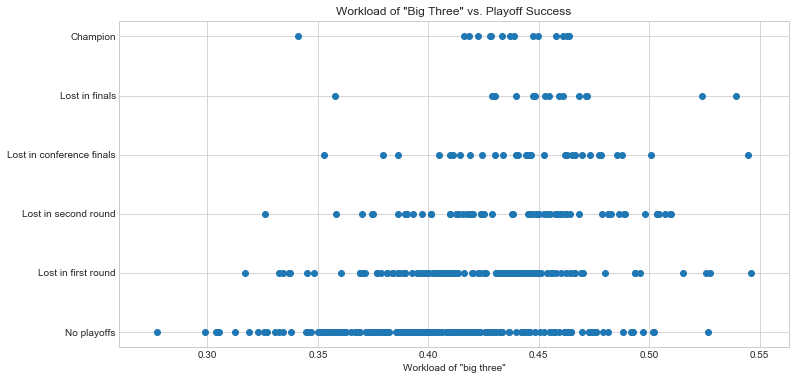

In [382]:
plt.figure(figsize=(12,6))
plt.scatter(s_res['big3'], s_res['playoffs'])
#plt.scatter(s_res_past['gini'], s_res_past['playoffs'], c='r')
#plt.scatter(s_res_recent['gini'], s_res_recent['playoffs'], c='b')
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Workload of "big three"')
plt.title('Workload of "Big Three" vs. Playoff Success')
plt.show()

In [385]:
labels = ['No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion']
s_res['labels'] = [labels[i] for i in s_res['playoffs']]

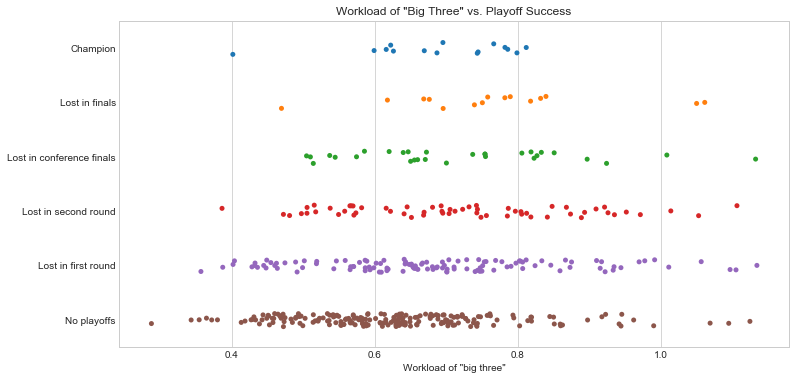

In [386]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))
sns.stripplot(x="palma", y="labels", data=s_res, jitter=0.12, 
              order=['Champion','Lost in finals','Lost in conference finals',
                     'Lost in second round','Lost in first round','No playoffs'])
plt.ylabel('')
plt.xlabel('Workload of "big three"')
plt.title('Workload of "Big Three" vs. Playoff Success')
plt.show()

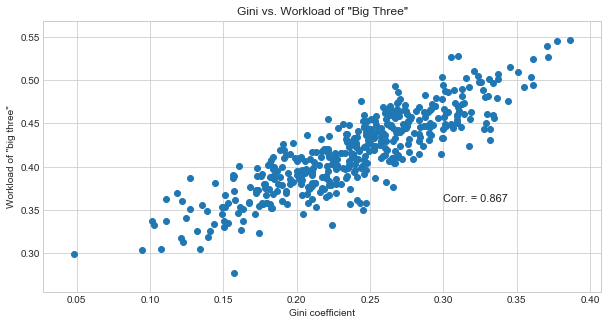

In [389]:
plt.figure(figsize=(10,5))
plt.scatter(s_res['gini'], s_res['big3'])
corr = round(np.corrcoef(s_res_gini['gini'], s_res['big3'])[0][1], 3)
plt.text(.3,.36,'Corr. = ' + str(corr), fontsize=11)
plt.xlabel('Gini coefficient')
plt.ylabel('Workload of "big three"')
plt.title('Gini vs. Workload of "Big Three"')
plt.show()

## Plot Palma

In [323]:
s_res = s_res[s_res['yr'] >= 2003]

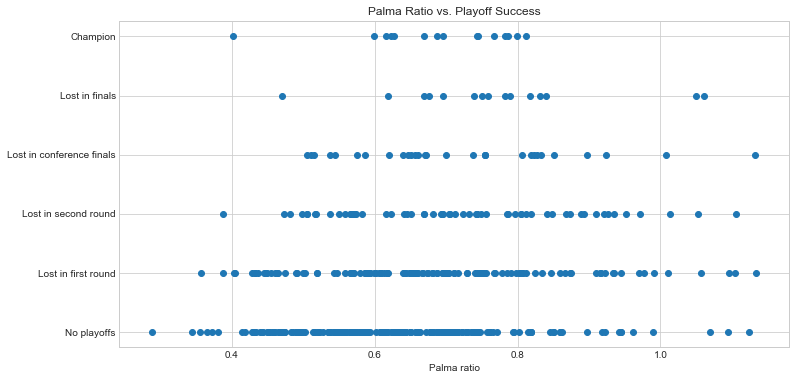

In [342]:
plt.figure(figsize=(12,6))
plt.scatter(s_res['palma'], s_res['playoffs'])
#plt.scatter(s_res_past['gini'], s_res_past['playoffs'], c='r')
#plt.scatter(s_res_recent['gini'], s_res_recent['playoffs'], c='b')
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Palma ratio')
plt.title('Palma Ratio vs. Playoff Success')
plt.show()

In [326]:
labels = ['No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion']
s_res['labels'] = [labels[i] for i in s_res['playoffs']]

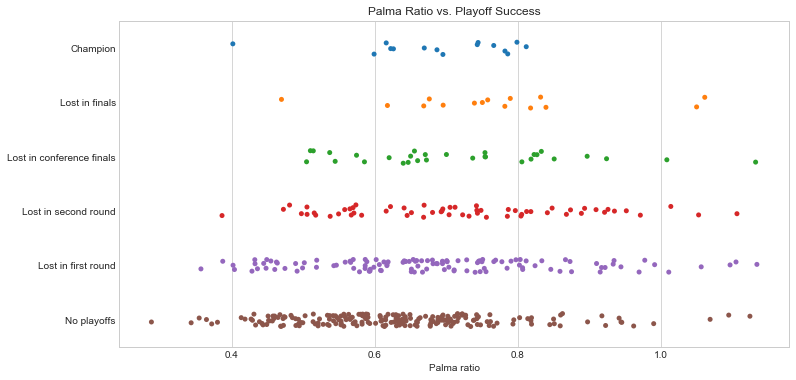

In [343]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))
sns.stripplot(x="palma", y="labels", data=s_res, jitter=0.12, 
              order=['Champion','Lost in finals','Lost in conference finals',
                     'Lost in second round','Lost in first round','No playoffs'])
plt.ylabel('')
plt.xlabel('Palma ratio')
plt.title('Palma Ratio vs. Playoff Success')
plt.show()

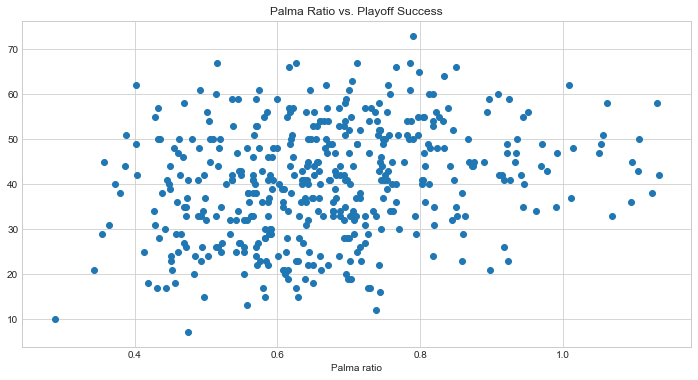

array([[ 1.        ,  0.25251838],
       [ 0.25251838,  1.        ]])

In [344]:
plt.figure(figsize=(12,6))
plt.scatter(s_res['palma'], s_res['W'])
#plt.scatter(s_res_past['gini'], s_res_past['playoffs'], c='r')
#plt.scatter(s_res_recent['gini'], s_res_recent['playoffs'], c='b')
#plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
#                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Palma ratio')
plt.title('Palma Ratio vs. Playoff Success')
plt.show()
np.corrcoef(s_res['palma'], s_res['W'])

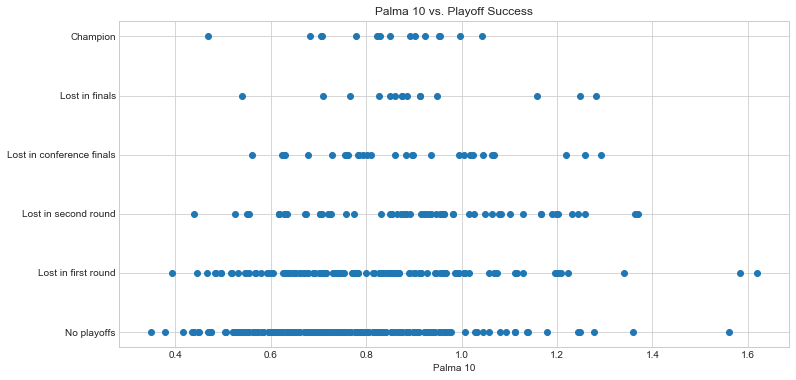

In [345]:
plt.figure(figsize=(12,6))
plt.scatter(s_res['palma10'], s_res['playoffs'])
#plt.scatter(s_res_past['gini'], s_res_past['playoffs'], c='r')
#plt.scatter(s_res_recent['gini'], s_res_recent['playoffs'], c='b')
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Palma 10')
plt.title('Palma 10 vs. Playoff Success')
plt.show()

In [309]:
s_res_gini = pd.read_excel('data/nba_results_gini_new.xlsx')
s_res_gini = s_res_gini[s_res_gini['yr'] >= 2003]

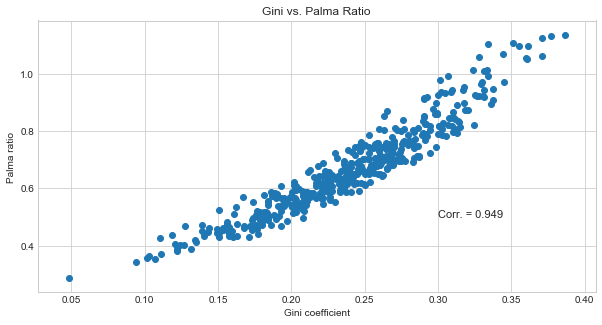

In [341]:
plt.figure(figsize=(10,5))
plt.scatter(s_res_gini['gini'], s_res['palma'])
plt.xlabel('Gini coefficient')
plt.ylabel('Palma ratio')
plt.title('Gini vs. Palma Ratio')
corr = round(np.corrcoef(s_res_gini['gini'], s_res['palma'])[0][1], 3)
plt.text(.3,.5,'Corr. = ' + str(corr), fontsize=11)
plt.show()



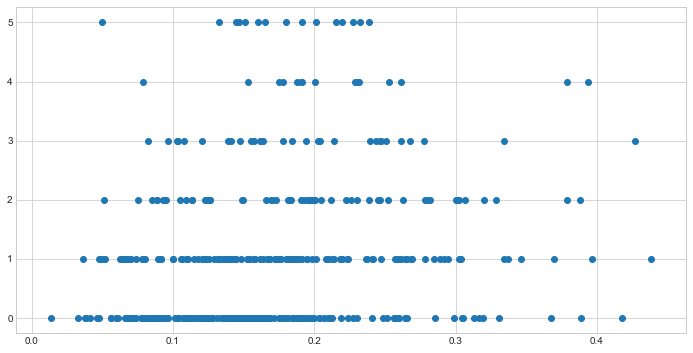

In [322]:
plt.figure(figsize=(12,6))
plt.scatter([g*p for g,p in zip(s_res_gini['gini'], s_res['palma'])], s_res['playoffs'])
plt.show()

## 7. Plot Gini vs. playoffs

In [170]:
s_res = pd.read_excel('data/nba_results_gini_new.xlsx')

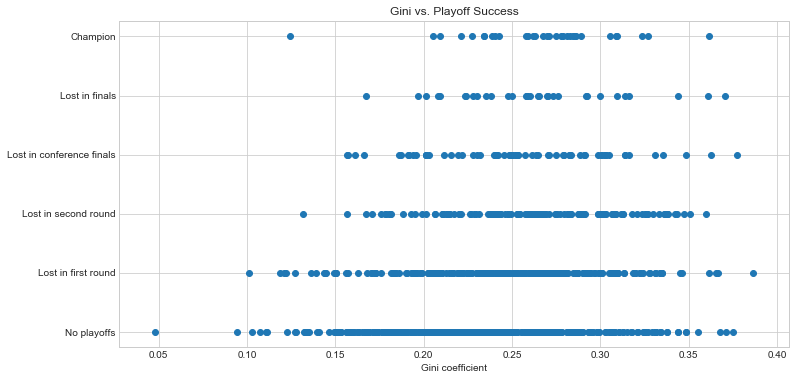

In [171]:
plt.figure(figsize=(12,6))
plt.scatter(s_res['gini'], s_res['playoffs'])
#plt.scatter(s_res_past['gini'], s_res_past['playoffs'], c='r')
#plt.scatter(s_res_recent['gini'], s_res_recent['playoffs'], c='b')
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Gini coefficient')
plt.title('Gini vs. Playoff Success')
plt.show()

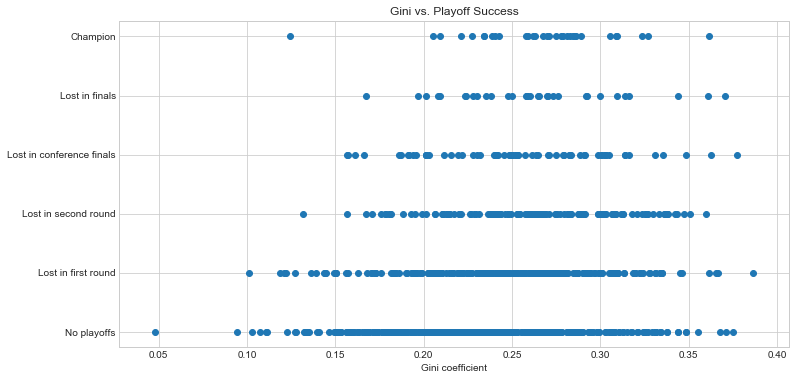

In [172]:
plt.figure(figsize=(12,6))
plt.scatter(s_res['gini'], s_res['playoffs'])
#plt.scatter(s_res_past['gini'], s_res_past['playoffs'], c='r')
#plt.scatter(s_res_recent['gini'], s_res_recent['playoffs'], c='b')
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Gini coefficient')
plt.title('Gini vs. Playoff Success')
plt.show()

In [173]:
labels = ['No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion']
s_res['labels'] = [labels[i] for i in s_res['playoffs']]

In [174]:
s_res.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,gini,labels
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,3,0.211476,Lost in conference finals
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4,0.292304,Lost in finals
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,2,0.258728,Lost in second round
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,2,0.329842,Lost in second round
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,1,0.239535,Lost in first round


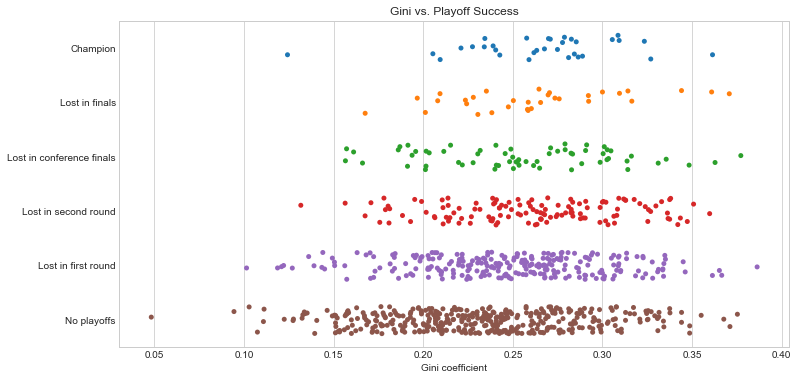

In [175]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))
sns.stripplot(x="gini", y="labels", data=s_res, jitter=0.25, 
              order=['Champion','Lost in finals','Lost in conference finals',
                     'Lost in second round','Lost in first round','No playoffs'])
plt.ylabel('')
plt.xlabel('Gini coefficient')
plt.title('Gini vs. Playoff Success')
plt.show()

In [176]:
len(s_res)

907

In [177]:
split = 2003
s_res_recent = s_res[s_res['yr'] >= split]
s_res_past = s_res[s_res['yr'] < split]

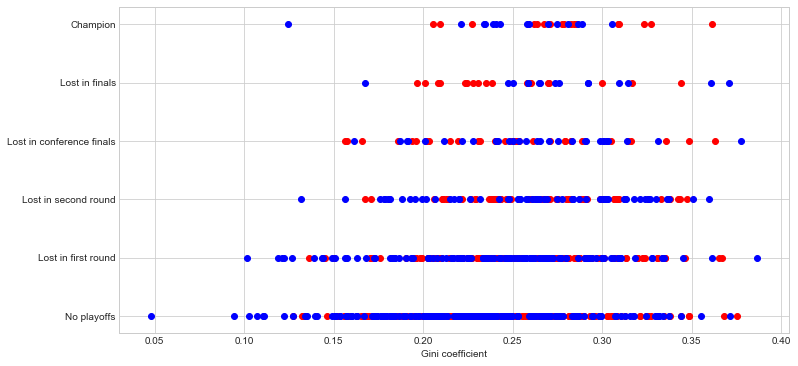

In [178]:
plt.figure(figsize=(12,6))
plt.scatter(s_res_past['gini'], s_res_past['playoffs'], c='r')
plt.scatter(s_res_recent['gini'], s_res_recent['playoffs'], c='b')
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Gini coefficient')
plt.show()

In [179]:
s_res = s_res[s_res['yr'] >= 2003]

In [180]:
len(s_res)

448

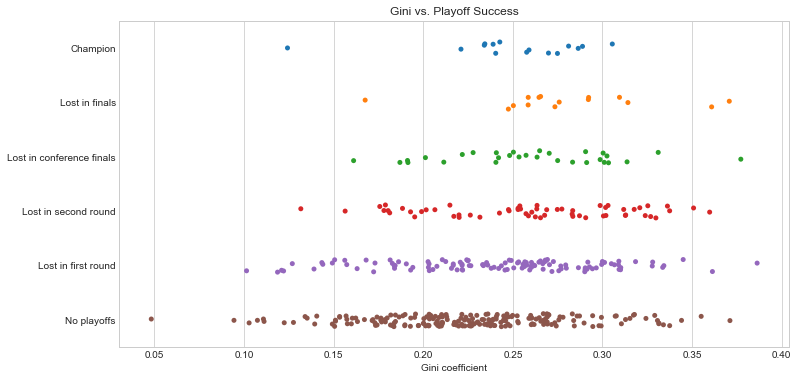

In [181]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))
sns.stripplot(x="gini", y="labels", data=s_res, jitter=0.12, 
              order=['Champion','Lost in finals','Lost in conference finals',
                     'Lost in second round','Lost in first round','No playoffs'])
plt.ylabel('')
plt.xlabel('Gini coefficient')
plt.title('Gini vs. Playoff Success')
plt.show()

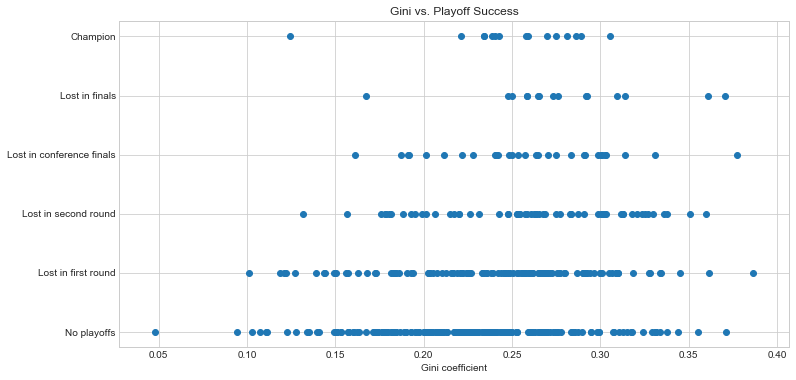

In [182]:
plt.figure(figsize=(12,6))
plt.scatter(s_res['gini'], s_res['playoffs'])
#plt.scatter(s_res_past['gini'], s_res_past['playoffs'], c='r')
#plt.scatter(s_res_recent['gini'], s_res_recent['playoffs'], c='b')
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Gini coefficient')
plt.title('Gini vs. Playoff Success')
plt.show()

In [183]:
tier0 = s_res[s_res['playoffs'] == 0]
tier1 = s_res[s_res['playoffs'] == 1]
tier2 = s_res[s_res['playoffs'] == 2]
tier3 = s_res[s_res['playoffs'] == 3]
tier4 = s_res[s_res['playoffs'] == 4]
tier5 = s_res[s_res['playoffs'] == 5]

In [184]:
print np.median(tier5['gini'])
print tier5[tier5['gini'] < 0.20]

0.257728036585
                  Team   W   L  WL_pct  PW  PL   PS/G  PA/G    yr abbr  \
115  San Antonio Spurs  62  20   0.756  61  21  105.4  97.6  2014  SAS   

     playoffs      gini    labels  
115         5  0.124244  Champion  


In [185]:
iqr = stats.iqr(tier5['gini'])
p25 = np.percentile(tier5['gini'], 25)
p75 = np.percentile(tier5['gini'], 75)
bounds = (p25 - 1.5*iqr, p75 + 1.5*iqr)
bounds

(0.17470694750965254, 0.34000060843338442)

In [186]:
g = .5
[bounds[0] <= g <= bounds[1] for g in tier5['gini']]

[True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [187]:
def find_outliers(tier_n):
    tier = s_res[s_res['playoffs'] == tier_n]
    iqr = stats.iqr(tier['gini'])
    p25 = np.percentile(tier['gini'], 25)
    p75 = np.percentile(tier['gini'], 75)
    bounds = (p25 - 1.5*iqr, p75 + 1.5*iqr)
    return [bounds[0] <= g <= bounds[1] for g in tier['gini']]

In [188]:
type(find_outliers(0))

list

In [189]:
tier0.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,gini,labels
8,Miami Heat,41,41,0.500,44,38,103.2,102.1,2017,MIA,0,0.203298,No playoffs
9,Detroit Pistons,37,45,0.451,38,44,101.3,102.5,2017,DET,0,0.186527,No playoffs
10,Charlotte Hornets,36,46,0.439,42,40,104.9,104.7,2017,CHH,0,0.230404,No playoffs
11,New York Knicks,31,51,0.378,31,51,104.3,108.0,2017,NYK,0,0.228384,No playoffs
12,Orlando Magic,29,53,0.354,24,58,101.1,107.6,2017,ORL,0,0.173385,No playoffs


In [190]:
len(tier0) == len(find_outliers(0))

True

In [191]:
pd.set_option('mode.chained_assignment', None)
tier0_out = find_outliers(0)
tier0['not_outlier'] = tier0_out
tier1_out = find_outliers(1)
tier1['not_outlier'] = tier1_out
tier2_out = find_outliers(2)
tier2['not_outlier'] = tier2_out
tier3_out = find_outliers(3)
tier3['not_outlier'] = tier3_out
tier4_out = find_outliers(4)
tier4['not_outlier'] = tier4_out
tier5_out = find_outliers(5)
tier5['not_outlier'] = tier5_out

In [192]:
tier0.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,gini,labels,not_outlier
8,Miami Heat,41,41,0.500,44,38,103.2,102.1,2017,MIA,0,0.203298,No playoffs,True
9,Detroit Pistons,37,45,0.451,38,44,101.3,102.5,2017,DET,0,0.186527,No playoffs,True
10,Charlotte Hornets,36,46,0.439,42,40,104.9,104.7,2017,CHH,0,0.230404,No playoffs,True
11,New York Knicks,31,51,0.378,31,51,104.3,108.0,2017,NYK,0,0.228384,No playoffs,True
12,Orlando Magic,29,53,0.354,24,58,101.1,107.6,2017,ORL,0,0.173385,No playoffs,True


In [193]:
n = 5
print sum(find_outliers(n))
print len(find_outliers(n))

14
15


In [194]:
print 'Mean of tier 0:', np.mean(tier0['gini'])
print 'Mean of tier 1:', np.mean(tier1['gini'])
print 'Mean of tier 2:', np.mean(tier2['gini'])
print 'Mean of tier 3:', np.mean(tier3['gini'])
print 'Mean of tier 4:', np.mean(tier4['gini'])
print 'Mean of tier 5:', np.mean(tier5['gini'])

Mean of tier 0: 0.225726735748
Mean of tier 1: 0.241547222355
Mean of tier 2: 0.259491710818
Mean of tier 3: 0.259770085939
Mean of tier 4: 0.280131711315
Mean of tier 5: 0.25063430318


In [195]:
print 'Median of tier 0:', np.median(tier0['gini'])
print 'Median of tier 1:', np.median(tier1['gini'])
print 'Median of tier 2:', np.median(tier2['gini'])
print 'Median of tier 3:', np.median(tier3['gini'])
print 'Median of tier 4:', np.median(tier4['gini'])
print 'Median of tier 5:', np.median(tier5['gini'])

Median of tier 0: 0.226469945095
Median of tier 1: 0.248576834725
Median of tier 2: 0.262965992174
Median of tier 3: 0.260453259936
Median of tier 4: 0.273491733307
Median of tier 5: 0.257728036585


In [196]:
print np.var(tier0['gini'])
print np.var(tier1['gini'])
print np.var(tier2['gini'])
print np.var(tier3['gini'])
print np.var(tier4['gini'])
print np.var(tier5['gini'])

0.00281326443915
0.00307647818532
0.00282234925419
0.00224055050859
0.00220943771411
0.00169737710643


## Without outliers

In [197]:
s_res_recompiled = pd.concat([tier0, tier1, tier2, tier3, tier4, tier5])
s_res_no_out = s_res_recompiled[s_res_recompiled['not_outlier'] == True]

In [198]:
s_res_out = s_res_recompiled[s_res_recompiled['not_outlier'] == False]

In [199]:
s_res_out

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,gini,labels,not_outlier
44,Philadelphia 76ers,10,72,0.122,16,66,97.4,107.6,2016,PHI,0,0.048224,No playoffs,False
331,Philadelphia 76ers,38,44,0.463,35,47,99.4,101.3,2006,PHI,0,0.371172,No playoffs,False
341,Washington Wizards,42,40,0.512,46,36,101.7,99.8,2006,WAS,1,0.386343,Lost in first round,False
388,Memphis Grizzlies,45,37,0.549,48,34,93.4,91.1,2005,MEM,1,0.101395,Lost in first round,False
145,San Antonio Spurs,58,24,0.707,58,24,103.0,96.6,2013,SAS,4,0.167584,Lost in finals,False
190,Miami Heat,58,24,0.707,61,21,102.1,94.6,2011,MIA,4,0.370803,Lost in finals,False
115,San Antonio Spurs,62,20,0.756,61,21,105.4,97.6,2014,SAS,5,0.124244,Champion,False


In [200]:
tier0 = s_res_no_out[s_res_no_out['playoffs'] == 0]
tier1 = s_res_no_out[s_res_no_out['playoffs'] == 1]
tier2 = s_res_no_out[s_res_no_out['playoffs'] == 2]
tier3 = s_res_no_out[s_res_no_out['playoffs'] == 3]
tier4 = s_res_no_out[s_res_no_out['playoffs'] == 4]
tier5 = s_res_no_out[s_res_no_out['playoffs'] == 5]

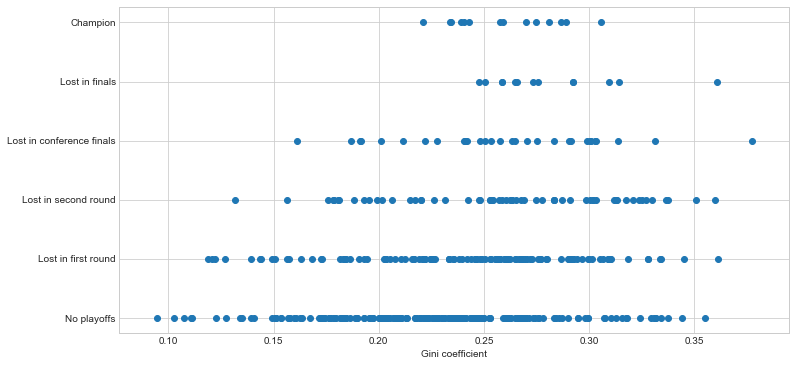

In [201]:
plt.figure(figsize=(12,6))
plt.scatter(s_res_no_out['gini'], s_res_no_out['playoffs'])
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Gini coefficient')
plt.show()

In [202]:
max(tier5['gini'])

0.30551889104317

In [203]:
# Tier 4 - percent in range (no outliers)
float(sum([0.22 <= s <= 0.31 for s in tier4['gini']]))/len(tier4['gini'])

0.8461538461538461

In [204]:
# Tier 4 - percent in range (all data)
float(sum([0.22 <= s <= 0.31 for s in tier4['gini']]))/(len(tier4['gini']) + 2)

0.7333333333333333

In [205]:
# Tier 5 - percent in range (no outliers)
float(sum([0.22 <= s <= 0.31 for s in tier5['gini']]))/len(tier5['gini'])

1.0

In [206]:
# Tier 5 - percent in range (all data)
float(sum([0.22 <= s <= 0.31 for s in tier5['gini']]))/(len(tier5['gini']) + 1)

0.9333333333333333

In [207]:
# Tier 4 and 5 - percent in range (no outliers)
float(sum([0.22 <= s <= 0.31 for s in tier4['gini']]) + 
      sum([0.22 <= s <= 0.31 for s in tier5['gini']])) / (len(tier4['gini']) + len(tier5['gini']))

0.9259259259259259

In [208]:
# Tier 4 and 5 - percent in range (all data)
float(sum([0.22 <= s <= 0.31 for s in tier4['gini']]) + 
      sum([0.22 <= s <= 0.31 for s in tier5['gini']])) / (len(tier4['gini']) + len(tier5['gini']) + 3)

0.8333333333333334

In [209]:
# All tiers - percent in range 
float(sum([0.22 <= s <= 0.31 for s in tier0['gini']]) + 
      sum([0.22 <= s <= 0.31 for s in tier1['gini']]) + 
      sum([0.22 <= s <= 0.31 for s in tier2['gini']]) + 
      sum([0.22 <= s <= 0.31 for s in tier3['gini']]))/(len(tier0['gini']) +
                                                        len(tier1['gini']) + 
                                                        len(tier2['gini']) + 
                                                        len(tier3['gini']))

0.5434782608695652

In [210]:
# All tiers - percent in range 
float(sum([0.22 <= s <= 0.31 for s in tier0['gini']]) + 
      sum([0.22 <= s <= 0.31 for s in tier1['gini']]) + 
      sum([0.22 <= s <= 0.31 for s in tier2['gini']]) + 
      sum([0.22 <= s <= 0.31 for s in tier3['gini']]))/(len(tier0['gini']) +
                                                        len(tier1['gini']) + 
                                                        len(tier2['gini']) + 
                                                        len(tier3['gini']) + 4)

0.5382775119617225

In [211]:
len(s_res_no_out)

441

In [215]:
# Means
print np.mean(tier0['gini'])
print np.mean(tier1['gini'])
print np.mean(tier2['gini'])
print np.mean(tier3['gini'])
print np.mean(tier4['gini'])
print np.mean(tier5['gini'])

0.225882356298
0.241507872216
0.259491710818
0.259770085939
0.281814531234
0.259662211518


In [216]:
# Medians
print np.median(tier0['gini'])
print np.median(tier1['gini'])
print np.median(tier2['gini'])
print np.median(tier3['gini'])
print np.median(tier4['gini'])
print np.median(tier5['gini'])

0.226469945095
0.248576834725
0.262965992174
0.260453259936
0.273491733307
0.258376909338


In [217]:
# Variances
print np.var(tier0['gini'])
print np.var(tier1['gini'])
print np.var(tier2['gini'])
print np.var(tier3['gini'])
print np.var(tier4['gini'])
print np.var(tier5['gini'])

0.00258491495149
0.00278448130925
0.00282234925419
0.00224055050859
0.000939727200067
0.00059607139379


In [219]:
df1 = s_res[s_res['gini'] <= 0.1]
df2 = s_res[(s_res['gini'] > 0.1) & (s_res['gini'] <= 0.15)]
df3 = s_res[(s_res['gini'] > 0.15) & (s_res['gini'] <= 0.2)]
df4 = s_res[(s_res['gini'] > 0.2) & (s_res['gini'] <= 0.25)]
df5 = s_res[(s_res['gini'] > 0.25) & (s_res['gini'] <= 0.3)]
df6 = s_res[(s_res['gini'] > 0.3) & (s_res['gini'] <= 0.35)]
df7 = s_res[s_res['gini'] > 0.35]

In [227]:
len(s_res[(s_res['gini'] > 0.1) & (s_res['gini'] < 0.35)])/float(len(s_res))

0.9754464285714286

In [220]:
a = float(sum(df1['playoffs']))/len(df1)
b = float(sum(df2['playoffs']))/len(df2)
c = float(sum(df3['playoffs']))/len(df3)
d = float(sum(df4['playoffs']))/len(df4)
e = float(sum(df5['playoffs']))/len(df5)
f = float(sum(df6['playoffs']))/len(df6)
g = float(sum(df7['playoffs']))/len(df7)
(a,b,c,d,e,f,g)

(0.0,
 0.7272727272727273,
 0.6842105263157895,
 0.7581699346405228,
 1.4210526315789473,
 1.4150943396226414,
 1.8888888888888888)

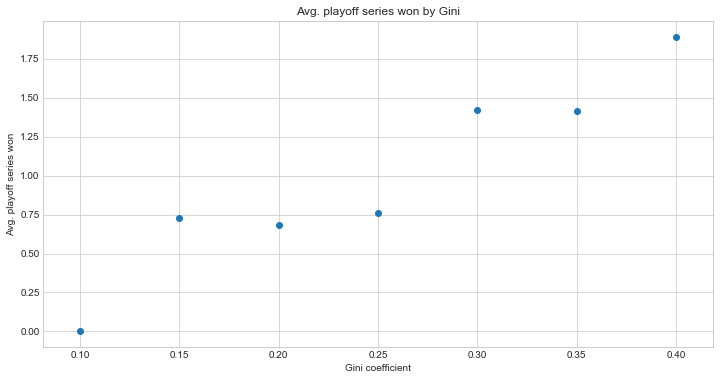

In [221]:
plt.figure(figsize=(12,6))
plt.scatter([.1,.15,.2,.25,.3,.35,.4],[a,b,c,d,e,f,g])
plt.ylabel('Avg. playoff series won')
plt.xlabel('Gini coefficient')
plt.title('Avg. playoff series won by Gini')
plt.show()

In [222]:
import scipy.stats as st
from scipy.stats import t
print t.interval(0.95, len(df1['playoffs'])-1, loc=np.mean(df1['playoffs']), scale=st.sem(df1['playoffs']))[0]

nan


In [223]:
intervals = []
intervals.append(t.interval(0.95, len(df1['playoffs'])-1, loc=np.mean(df1['playoffs']), scale=st.sem(df1['playoffs'])))
intervals.append(t.interval(0.95, len(df2['playoffs'])-1, loc=np.mean(df2['playoffs']), scale=st.sem(df2['playoffs'])))
intervals.append(t.interval(0.95, len(df3['playoffs'])-1, loc=np.mean(df3['playoffs']), scale=st.sem(df3['playoffs'])))
intervals.append(t.interval(0.95, len(df4['playoffs'])-1, loc=np.mean(df4['playoffs']), scale=st.sem(df4['playoffs'])))
intervals.append(t.interval(0.95, len(df5['playoffs'])-1, loc=np.mean(df5['playoffs']), scale=st.sem(df5['playoffs'])))
intervals.append(t.interval(0.95, len(df6['playoffs'])-1, loc=np.mean(df6['playoffs']), scale=st.sem(df6['playoffs'])))
intervals.append(t.interval(0.95, len(df7['playoffs'])-1, loc=np.mean(df7['playoffs']), scale=st.sem(df7['playoffs'])))

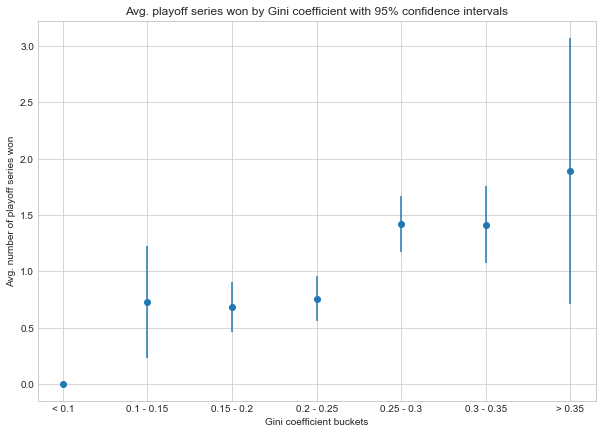

In [224]:
plt.figure(figsize=(10,7))

plt.errorbar(x=range(7), 
             y=[a,b,c,d,e,f,g], 
             yerr=[(top-bot)/2 for top,bot in intervals],
             fmt='o')
plt.ylabel('Avg. number of playoff series won')
plt.xlabel('Gini coefficient buckets')
plt.xticks(range(7), ('< 0.1', '0.1 - 0.15', '0.15 - 0.2', '0.2 - 0.25', '0.25 - 0.3', '0.3 - 0.35', '> 0.35'))
plt.title('Avg. playoff series won by Gini coefficient with 95% confidence intervals')
plt.show()

#plt.hlines(xmin=0, xmax=25,
#           y=43.0023, 
#           linewidth=2.0,
#           color="red")

## Since 2003, remove outliers

In [188]:
tier0 = s_res_recent[s_res_recent['playoffs'] == 0]
tier1 = s_res_recent[s_res_recent['playoffs'] == 1]
tier2 = s_res_recent[s_res_recent['playoffs'] == 2]
tier3 = s_res_recent[s_res_recent['playoffs'] == 3]
tier4 = s_res_recent[s_res_recent['playoffs'] == 4]
tier5 = s_res_recent[s_res_recent['playoffs'] == 5]

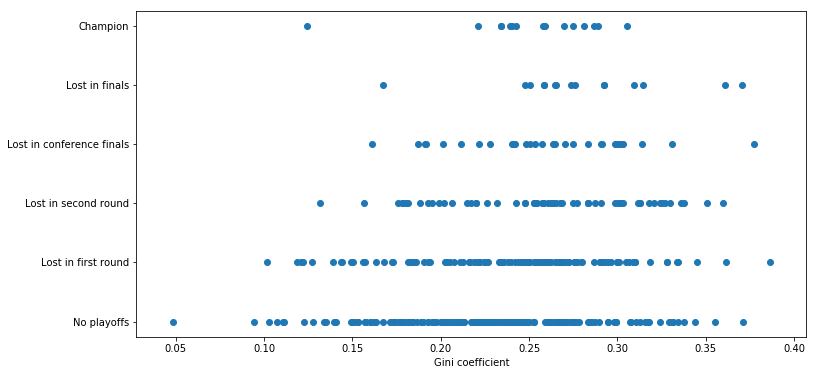

In [114]:
plt.figure(figsize=(12,6))
plt.scatter(s_res_recent['gini'], s_res_recent['playoffs'])
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Gini coefficient')
plt.show()

In [189]:
def find_outliers(tier_n):
    tier = s_res_recent[s_res_recent['playoffs'] == tier_n]
    iqr = stats.iqr(tier['gini'])
    p25 = np.percentile(tier['gini'], 25)
    p75 = np.percentile(tier['gini'], 75)
    bounds = (p25 - 1.5*iqr, p75 + 1.5*iqr)
    return [bounds[0] <= g <= bounds[1] for g in tier['gini']]

In [190]:
pd.set_option('mode.chained_assignment', None)
tier0_out = find_outliers(0)
tier0['not_outlier'] = tier0_out
tier1_out = find_outliers(1)
tier1['not_outlier'] = tier1_out
tier2_out = find_outliers(2)
tier2['not_outlier'] = tier2_out
tier3_out = find_outliers(3)
tier3['not_outlier'] = tier3_out
tier4_out = find_outliers(4)
tier4['not_outlier'] = tier4_out
tier5_out = find_outliers(5)
tier5['not_outlier'] = tier5_out

In [200]:
n = 0
print sum(find_outliers(n))
print len(find_outliers(n))

206
208


In [196]:
tier4

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,gini,not_outlier
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4,0.292306,True
45,Golden State Warriors,73,9,0.890,65,17,114.9,104.1,2016,GSW,4,0.292161,True
65,Cleveland Cavaliers,53,29,0.646,53,29,103.1,98.7,2015,CLE,4,0.309535,True
100,Miami Heat,54,28,0.659,54,28,102.2,97.4,2014,MIA,4,0.258602,True
145,San Antonio Spurs,58,24,0.707,58,24,103.0,96.6,2013,SAS,4,0.167584,False
165,Oklahoma City Thunder,47,19,0.712,46,20,103.1,96.9,2012,OKC,4,0.360955,True
190,Miami Heat,58,24,0.707,61,21,102.1,94.6,2011,MIA,4,0.370806,False
210,Boston Celtics,50,32,0.610,52,30,99.2,95.6,2010,BOS,4,0.265495,True
250,Orlando Magic,59,23,0.720,59,23,101.0,94.4,2009,ORL,4,0.273492,True
290,Los Angeles Lakers,57,25,0.695,59,23,108.6,101.3,2008,LAL,4,0.275881,True


In [201]:
s_res_recompiled = pd.concat([tier0, tier1, tier2, tier3, tier4, tier5])
s_res_no_out = s_res_recompiled[s_res_recompiled['not_outlier'] == True]

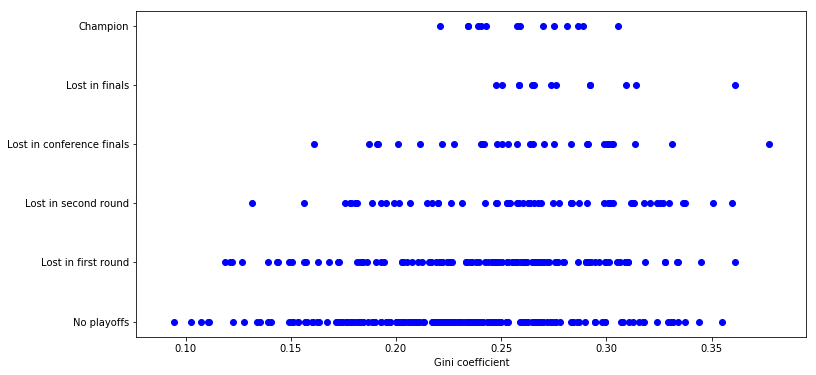

In [202]:
plt.figure(figsize=(12,6))
plt.scatter(s_res_no_out['gini'], s_res_no_out['playoffs'], c='b')
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Gini coefficient')
plt.show()

In [205]:
tier0 = s_res_no_out[s_res_no_out['playoffs'] == 0]
tier1 = s_res_no_out[s_res_no_out['playoffs'] == 1]
tier2 = s_res_no_out[s_res_no_out['playoffs'] == 2]
tier3 = s_res_no_out[s_res_no_out['playoffs'] == 3]
tier4 = s_res_no_out[s_res_no_out['playoffs'] == 4]
tier5 = s_res_no_out[s_res_no_out['playoffs'] == 5]

In [206]:
print 'Mean of tier 0:', np.mean(tier0['gini'])
print 'Mean of tier 1:', np.mean(tier1['gini'])
print 'Mean of tier 2:', np.mean(tier2['gini'])
print 'Mean of tier 3:', np.mean(tier3['gini'])
print 'Mean of tier 4:', np.mean(tier4['gini'])
print 'Mean of tier 5:', np.mean(tier5['gini'])

Mean of tier 0: 0.225883524202
Mean of tier 1: 0.24150958198
Mean of tier 2: 0.259492769835
Mean of tier 3: 0.259772327498
Mean of tier 4: 0.281816805698
Mean of tier 5: 0.25966418227


In [207]:
print 'Median of tier 0:', np.median(tier0['gini'])
print 'Median of tier 1:', np.median(tier1['gini'])
print 'Median of tier 2:', np.median(tier2['gini'])
print 'Median of tier 3:', np.median(tier3['gini'])
print 'Median of tier 4:', np.median(tier4['gini'])
print 'Median of tier 5:', np.median(tier5['gini'])

Median of tier 0: 0.226471688668
Median of tier 1: 0.248576834725
Median of tier 2: 0.262968030585
Median of tier 3: 0.260455100737
Median of tier 4: 0.273491733307
Median of tier 5: 0.258379488633


In [208]:
print 'Var. of tier 0:', np.var(tier0['gini'])
print 'Var. of tier 1:', np.var(tier1['gini'])
print 'Var. of tier 2:', np.var(tier2['gini'])
print 'Var. of tier 3:', np.var(tier3['gini'])
print 'Var. of tier 4:', np.var(tier4['gini'])
print 'Var. of tier 5:', np.var(tier5['gini'])

Var. of tier 0: 0.00258492381851
Var. of tier 1: 0.00278450642755
Var. of tier 2: 0.00282236358417
Var. of tier 3: 0.00224059656071
Var. of tier 4: 0.000939756928565
Var. of tier 5: 0.000596080844282


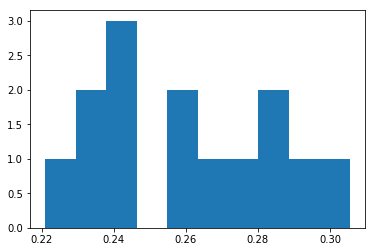

In [220]:
plt.hist(tier5['gini'], bins=10)
plt.show()

In [221]:
df1 = s_res_no_out[s_res_no_out['gini'] <= 0.1]
df2 = s_res_no_out[(s_res_no_out['gini'] > 0.1) & (s_res_no_out['gini'] <= 0.2)]
df3 = s_res_no_out[(s_res_no_out['gini'] > 0.2) & (s_res_no_out['gini'] <= 0.3)]
df4 = s_res_no_out[s_res_no_out['gini'] > 0.3]

In [224]:
print float(sum(df1['playoffs'] == 5))/len(df1)
print float(sum(df2['playoffs'] == 5))/len(df2)
print float(sum(df3['playoffs'] == 5))/len(df3)
print float(sum(df4['playoffs'] == 5))/len(df4)

0.0
0.0
0.0454545454545
0.0169491525424


In [225]:
df1 = s_res_no_out[s_res_no_out['gini'] <= 0.1]
df2 = s_res_no_out[(s_res_no_out['gini'] > 0.1) & (s_res_no_out['gini'] <= 0.15)]
df3 = s_res_no_out[(s_res_no_out['gini'] > 0.15) & (s_res_no_out['gini'] <= 0.2)]
df4 = s_res_no_out[(s_res_no_out['gini'] > 0.2) & (s_res_no_out['gini'] <= 0.25)]
df5 = s_res_no_out[(s_res_no_out['gini'] > 0.25) & (s_res_no_out['gini'] <= 0.3)]
df6 = s_res_no_out[(s_res_no_out['gini'] > 0.3) & (s_res_no_out['gini'] <= 0.35)]
df7 = s_res_no_out[s_res_no_out['gini'] > 0.35]

In [228]:
a = float(sum(df1['playoffs'] == 5))/len(df1)
b = float(sum(df2['playoffs'] == 5))/len(df2)
c = float(sum(df3['playoffs'] == 5))/len(df3)
d = float(sum(df4['playoffs'] == 5))/len(df4)
e = float(sum(df5['playoffs'] == 5))/len(df5)
f = float(sum(df6['playoffs'] == 5))/len(df6)
g = float(sum(df7['playoffs'] == 5))/len(df7)
(a,b,c,d,e,f,g)

(0.0,
 0.0,
 0.0,
 0.0392156862745098,
 0.05263157894736842,
 0.018867924528301886,
 0.0)

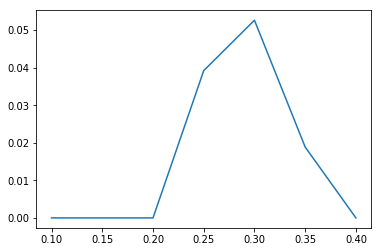

In [230]:
plt.plot([.1,.15,.2,.25,.3,.35,.4],[a,b,c,d,e,f,g])
plt.show()

In [241]:
def avg_series_wins(df):
    tot = 0
    for i in range(6):
        tot += (i * float(sum(df['playoffs'] == i)))
    return float(tot)/len(df)

In [246]:
print avg_series_wins(df1)
print avg_series_wins(df2)
print avg_series_wins(df3)
print avg_series_wins(df4)
print avg_series_wins(df5)
print avg_series_wins(df6)
print avg_series_wins(df7)

0.0
0.5
0.64
0.758169934641
1.42105263158
1.41509433962
2.0


In [247]:
len(df7)

6

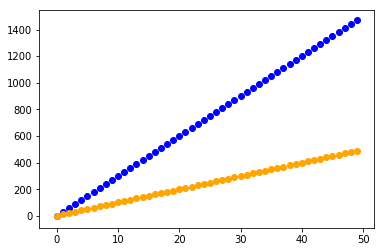

In [171]:
mps = range(50)
plt.scatter(mps, [m * (10 + 20) for m in mps], c='b')
#plt.scatter(mps, [m**2 * 20 for m in mps], c='r')
plt.scatter(mps, [m * 10 for m in mps], c='orange')
plt.show()

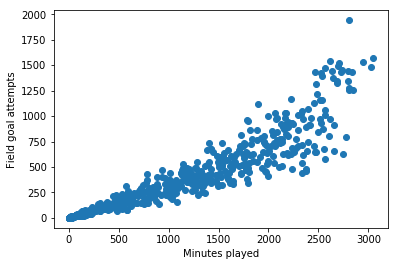

In [204]:
#plt.scatter([mp**(0.5) for mp in season_df['mp']], season_df['fga'])
#plt.scatter(season_df['mp'], [fg**(0.5) for fg in season_df['fga']])
plt.scatter(season_df['mp'], season_df['fga'])
plt.xlabel('Minutes played')
plt.ylabel('Field goal attempts')
plt.show()

## 8. Read in regression data and alter

In [248]:
res = pd.read_excel('data/regression_data_playoffs.xlsx')

In [249]:
res.head()

,W,def_rtg,off_rtg,team,yr,Z_def_rtg,Z_off_rtg,abbr,playoffs,gini
0,67,102.6,111.8,Boston Celtics,1986,-1.783167,1.423847,BOS,5,0.467711
1,57,102.7,111.4,Milwaukee Bucks,1986,-1.744543,1.300147,MIL,3,0.413512
2,62,105.8,113.3,Los Angeles Lakers,1986,-0.547181,1.887725,LAL,3,0.379010
3,50,105.6,107.9,Atlanta Hawks,1986,-0.624430,0.217765,ATL,2,0.504979
4,54,106.3,108.6,Philadelphia 76ers,1986,-0.354059,0.434241,PHI,2,0.504629


In [260]:
new_gini_lst = []
for i in range(len(res)):
    temp = s_res[(s_res['yr'] == res.iloc[i].yr) & (s_res['abbr'] == res.iloc[i].abbr)]
    g = temp['gini'].iloc[0]
    new_gini_lst.append(g)

In [262]:
res['new_gini'] = new_gini_lst

In [263]:
res.head()

,W,def_rtg,off_rtg,team,yr,Z_def_rtg,Z_off_rtg,abbr,playoffs,gini,new_gini
0,67,102.6,111.8,Boston Celtics,1986,-1.783167,1.423847,BOS,5,0.467711,0.270916
1,57,102.7,111.4,Milwaukee Bucks,1986,-1.744543,1.300147,MIL,3,0.413512,0.230453
2,62,105.8,113.3,Los Angeles Lakers,1986,-0.547181,1.887725,LAL,3,0.379010,0.203331
3,50,105.6,107.9,Atlanta Hawks,1986,-0.624430,0.217765,ATL,2,0.504979,0.259797
4,54,106.3,108.6,Philadelphia 76ers,1986,-0.354059,0.434241,PHI,2,0.504629,0.309131


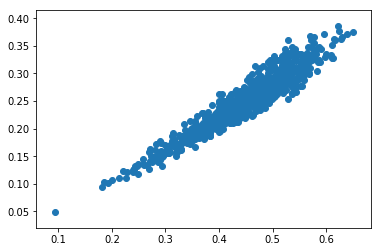

In [265]:
plt.scatter(res['gini'], res['new_gini'])
plt.show()

In [267]:
res.to_excel('data/regression_data_playoffs_new.xlsx')

## Find what pct. of workload is carried by top k players

In [330]:
df = pd.read_excel('data/season_data/season_data_2017.xlsx')

In [331]:
df.head()

,G,GS,age,ast,blk,drb,efg,fg,fg2,fg2_pct,...,orb,pf,player,pos,pts,stl,team,tov,trb,yr
0,68,6,23,40,8,68,0.531,134,40,0.426,...,18,114,Alex Abrines,SG,406,37,OKC,33,86,2017
1,38,1,26,18,15,95,0.521,70,33,0.413,...,20,67,Quincy Acy,PF,222,14,TOT,21,115,2017
2,6,0,26,0,0,6,0.324,5,4,0.400,...,2,9,Quincy Acy,PF,13,0,DAL,2,8,2017
3,32,1,26,18,15,89,0.542,65,29,0.414,...,18,58,Quincy Acy,PF,209,14,BRK,19,107,2017
4,80,80,23,86,78,332,0.571,374,374,0.572,...,281,195,Steven Adams,C,905,89,OKC,146,613,2017


In [336]:
def get_avg_usg(yr, k):
    df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    df = df[df['mp'] > 0]
    usg_lst = []
    for team in np.unique(df['team']):
        #print team, yr
        if team != 'TOT':
            team_df = df[df['team'] == team]
            usg = calculate_weighted_usg(team_df)
            n_usg = get_norm_usg(usg)
            usg_lst.append( (sum(n_usg[-k:])/sum(n_usg)) )
    return np.mean(usg_lst)

In [337]:
yrs = range(2003, 2018)
avg_usg_df = pd.DataFrame()
for yr in yrs:
    avg_usg_df = avg_usg_df.append({
            'yr': yr,
            'top8': get_avg_usg(yr, 8),
            'top9': get_avg_usg(yr, 9),
            'top10': get_avg_usg(yr, 10)
        }, ignore_index=True)

In [338]:
avg_usg_df

,top10,top8,top9,yr
0,0.926494,0.843968,0.890491,2003.0
1,0.898296,0.816133,0.860446,2004.0
2,0.899791,0.812577,0.860699,2005.0
3,0.908607,0.829065,0.872396,2006.0
4,0.914785,0.828471,0.876828,2007.0
5,0.914366,0.834715,0.879870,2008.0
6,0.911270,0.830179,0.875449,2009.0
7,0.910975,0.825904,0.871834,2010.0
8,0.890030,0.807036,0.852707,2011.0
9,0.888601,0.796986,0.846708,2012.0


In [341]:
np.mean(avg_usg_df['top9'])

0.8599106861249781